In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import NASNetLarge

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 32

In [ ]:
train_generator = train_datagen.flow_from_directory(
     os.path.join(drive_path, 'Train'),
    target_size=(331, 331),  # Adjust target size for NASNetLarge
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
)

Found 17028 images belonging to 38 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    os.path.join(drive_path, 'Train'),
    target_size=(331, 331),  # Adjust target size for NASNetLarge
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
)

Found 4257 images belonging to 38 classes.


In [ ]:
img_height, img_width = 224, 224  # Set the height and width of the input images
num_classes = 38  # Number of classes in the classification task

# Load NASNetLarge model pre-trained on ImageNet. 'include_top=False' removes the final fully connected layers.
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

# Freeze the weights of the convolutional layers in the NASNetLarge base model.
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head on top of the NASNetLarge base model
model = models.Sequential()
model.add(base_model)  # Add the pre-trained NASNetLarge base model
model.add(layers.GlobalAveragePooling2D())  # Use Global Average Pooling to reduce spatial dimensions
model.add(layers.Dense(256, activation='relu'))  # Add a dense layer with 256 units and ReLU activation function
model.add(layers.Dropout(0.5))  # Add a dropout layer with a dropout rate of 0.5 to reduce overfitting
model.add(layers.Dense(num_classes, activation='softmax'))  # Final dense layer with softmax activation for classification

# Compile the model using the Adam optimizer, categorical crossentropy loss function, and accuracy as the evaluation metric.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data using the generator, with validation on the validation data.
# 'steps_per_epoch' and 'validation_steps' define the number of batches per epoch during training and validation.
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,  # Train the model for 5 epochs, adjust as needed
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/5
533/533 [==============================] - 632s 1s/step - loss: 1.3416 - accuracy: 0.6190 - val_loss: 0.5410 - val_accuracy: 0.8478
Epoch 2/5
533/533 [==============================] - 580s 1s/step - loss: 0.6177 - accuracy: 0.8091 - val_loss: 0.3597 - val_accuracy: 0.8879
Epoch 3/5
533/533 [==============================] - 607s 1s/step - loss: 0.4581 - accuracy: 0.8535 - val_loss: 0.3109 - val_accuracy: 0.9027
Epoch 4/5
533/533 [==============================] - 579s 1s/step - loss: 0.3761 - accuracy: 0.8793 - val_loss: 0.2920 - val_accuracy: 0.9072
Epoch 5/5
533/533 [==============================] - 579s 1s/step - loss: 0.3338 - accuracy: 0.8909 - val_loss: 0.2698 - val_accuracy: 0.9147


In [ ]:
test_set = test_datagen.flow_from_directory(
    os.path.join(drive_path, 'Test'),
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_set, steps=len(test_set))
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Found 380 images belonging to 38 classes.
12/12 [==============================] - 6s 452ms/step - loss: 0.5797 - accuracy: 0.8553
Test Accuracy: 85.53%


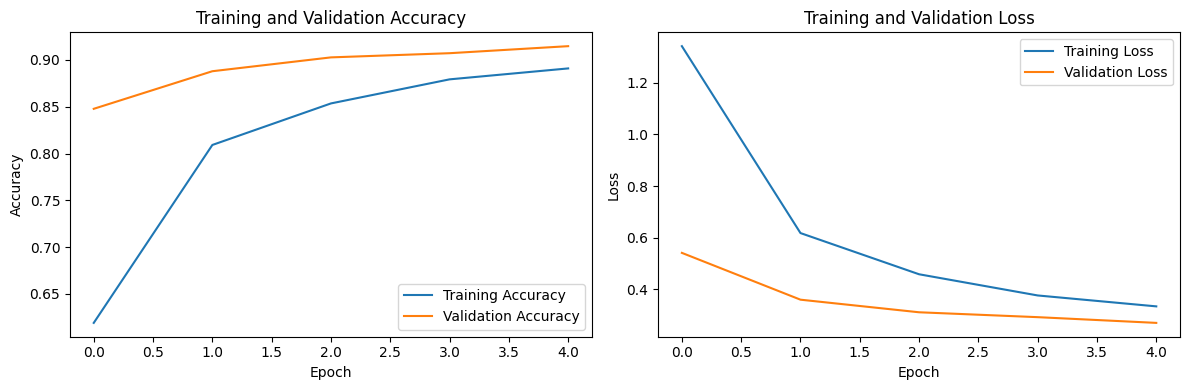

In [ ]:
plt.figure(figsize=(12, 4))
# Plot Training Accuracy and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Plot Training Loss and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 50ms/step
Test Image: /content/drive/MyDrive/NNP/Test/Tomato___Late_blight/0ab391bd-e5ba-479c-919b-3aa9a94f66db___GHLB2 Leaf 8934.JPG
Predicted Class: Tomato___Late_blight (Class Number: 30)


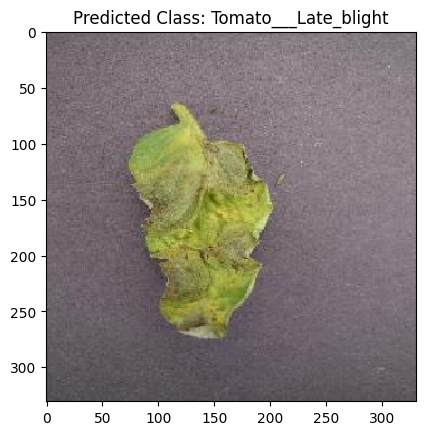

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
random_index = random.randint(0, len(test_set.filenames) - 1)
sample_path = os.path.join( os.path.join(drive_path, 'Test'), test_set.filenames[random_index])

img = load_img(sample_path, target_size=(331, 331))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale pixel values

prediction = model.predict(img_array)
predicted_class_number = np.argmax(prediction)
class_name = [k for k, v in test_set.class_indices.items() if v == predicted_class_number][0]
print(f'Test Image: {sample_path}')
print(f'Predicted Class: {class_name} (Class Number: {predicted_class_number})')
plt.imshow(img)
plt.title(f'Predicted Class: {class_name}')
plt.show()